In [1]:
import matplotlib.patches as patches
import Metrica_Viz as mviz
import Metrica_IO as mio
import numpy as np
import pandas as pd
from typing import List
from cmap import Colormap
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, KMeans, SpectralClustering
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
df_home = pd.read_csv("Sample_Game_2_RawTrackingData_Home_Team.csv", low_memory=False)
df_away = pd.read_csv("Sample_Game_2_RawTrackingData_Away_Team.csv", low_memory=False)

In [3]:
ball_x = df_home["Unnamed: 31"]
ball_y = df_home["Unnamed: 32"]

In [4]:
df_home = df_home.iloc[2:].reset_index()
df_home = df_home.drop(columns=["index"])
columns_to_drop = df_home.columns[df_home.iloc[0].isna()]
df_home = df_home.drop(columns=columns_to_drop)

In [5]:
df_home.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Home,Unnamed: 4,Home.1,Unnamed: 6,Home.2,Unnamed: 8,Home.3,...,Home.6,Unnamed: 16,Home.7,Unnamed: 18,Home.8,Unnamed: 20,Home.9,Unnamed: 22,Home.10,Unnamed: 24
0,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
1,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
2,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
3,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
4,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413


In [6]:
df_away = df_away.iloc[2:].reset_index()
df_away = df_away.drop(columns=["index"])
columns_to_drop = df_away.columns[df_away.iloc[0].isna()]
df_away = df_away.drop(columns=columns_to_drop)

In [7]:
df_away.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Away,Unnamed: 4,Away.1,Unnamed: 6,Away.2,Unnamed: 8,Away.3,...,Away.6,Unnamed: 16,Away.7,Unnamed: 18,Away.8,Unnamed: 20,Away.9,Unnamed: 22,Away.10,Unnamed: 24
0,1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
1,1,2,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
2,1,3,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
3,1,4,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
4,1,5,0.2,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234


In [8]:
def add_headers(data: pd.DataFrame, team):
    head = team + "-P_1-x"
    headers = [head]
    count = 1
    for i in range(4, df_home.shape[1]):
        if "x" in headers[count-1]:
            head = f"{team}-P_{(count//2)+1}-y"
        else:
            head = f"{team}-P_{(count//2)+1}-x"
        headers.append(head)
        count += 1
        
    headers = ["Period", "Frame", "Time[s]"] + headers

    return headers
    
df_home.columns = add_headers(df_home, "Home")
df_away.columns = add_headers(df_away, "Away")

In [9]:
df_home.head()

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Home-P_7-x,Home-P_7-y,Home-P_8-x,Home-P_8-y,Home-P_9-x,Home-P_9-y,Home-P_10-x,Home-P_10-y,Home-P_11-x,Home-P_11-y
0,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
1,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
2,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
3,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
4,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413


In [10]:
df_away.head()

,Period,Frame,Time[s],Away-P_1-x,Away-P_1-y,Away-P_2-x,Away-P_2-y,Away-P_3-x,Away-P_3-y,Away-P_4-x,...,Away-P_7-x,Away-P_7-y,Away-P_8-x,Away-P_8-y,Away-P_9-x,Away-P_9-y,Away-P_10-x,Away-P_10-y,Away-P_11-x,Away-P_11-y
0,1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
1,1,2,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
2,1,3,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
3,1,4,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
4,1,5,0.2,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234


## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [11]:
df_home['Period'] = pd.to_numeric(df_home['Period'], errors='coerce')
df_home["ball-x"], df_home["ball-y"] = ball_x, ball_y
period_1_data_home = df_home[df_home["Period"] == 1]
period_1_data_home = period_1_data_home[49:]

In [12]:
df_away['Period'] = pd.to_numeric(df_away['Period'], errors='coerce')
df_away["ball-x"], df_away["ball-y"] = ball_x, ball_y
period_1_data_away = df_away[df_away["Period"] == 1]
period_1_data_away = period_1_data_away[49:]

In [13]:
period_1_data_home.head()

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Home-P_8-x,Home-P_8-y,Home-P_9-x,Home-P_9-y,Home-P_10-x,Home-P_10-y,Home-P_11-x,Home-P_11-y,ball-x,ball-y
49,1,50,2,0.64779,0.27056,0.67763,0.42627,0.68182,0.54645,0.64443,...,0.53309,0.78647,0.50151,0.35328,0.50054,0.65342,0.94802,0.48966,NaN,NaN
50,1,51,2.04,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,...,0.53316,0.78648,0.5014,0.35295,0.50046,0.65322,0.94791,0.48986,NaN,NaN
51,1,52,2.08,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,...,0.53323,0.78651,0.50128,0.35261,0.50036,0.65297,0.94779,0.49005,NaN,NaN
52,1,53,2.12,0.64805,0.26978,0.67767,0.42637,0.6806,0.54582,0.64418,...,0.53328,0.78657,0.50115,0.35226,0.50025,0.65270,0.94766,0.49025,0.50216,0.50376
53,1,54,2.16,0.64815,0.26943,0.67769,0.42634,0.6802,0.54562,0.64409,...,0.53334,0.78658,0.50102,0.35198,0.50011,0.65247,0.94756,0.49039,0.5004,0.50384


In [14]:
period_1_data_away.head()

,Period,Frame,Time[s],Away-P_1-x,Away-P_1-y,Away-P_2-x,Away-P_2-y,Away-P_3-x,Away-P_3-y,Away-P_4-x,...,Away-P_8-x,Away-P_8-y,Away-P_9-x,Away-P_9-y,Away-P_10-x,Away-P_10-y,Away-P_11-x,Away-P_11-y,ball-x,ball-y
49,1,50,2,0.00315,0.50293,0.38522,0.82051,0.30852,0.56601,0.31473,...,0.43292,0.37749,0.49513,0.02253,0.50216,0.50401,0.49546,0.36198,NaN,NaN
50,1,51,2.04,0.00315,0.50293,0.38528,0.82061,0.3085,0.56600,0.31453,...,0.43295,0.37750,0.49511,0.02246,0.50216,0.50376,0.49565,0.36179,NaN,NaN
51,1,52,2.08,0.00315,0.50293,0.38535,0.82071,0.30849,0.56598,0.31434,...,0.43299,0.37743,0.49508,0.02249,0.50214,0.50371,0.4958,0.36160,NaN,NaN
52,1,53,2.12,0.00315,0.50293,0.38542,0.82083,0.30846,0.56595,0.31415,...,0.43305,0.37735,0.49507,0.02242,0.50209,0.50366,0.49587,0.36151,0.50216,0.50376
53,1,54,2.16,0.00315,0.50293,0.3855,0.82093,0.30845,0.56595,0.31398,...,0.43311,0.37727,0.49505,0.02235,0.50203,0.50361,0.49598,0.36131,0.5004,0.50384


In [15]:
def fill_nan_with_adjacent_average(data: pd.DataFrame) -> pd.DataFrame:
    """
    Fill NaN values in a DataFrame with the average of previous and next non-NaN values.
    
    Parameters:
    df_home (pd.DataFrame): Input DataFrame
    
    Returns:
    pd.DataFrame: DataFrame with NaN values filled
    """
    # Create a copy of the input DataFrame to avoid modifying the original
    df_filled = data.copy()
    
    # Iterate through each column
    for col in df_filled.columns:
        if pd.api.types.is_numeric_dtype(df_filled[col]):
            df_filled[col] = df_filled[col].interpolate(method="linear")
        df_filled[col] = df_filled[col].ffill().bfill()
    
    return df_filled

In [16]:
period_1_data_home = fill_nan_with_adjacent_average(period_1_data_home)
period_1_data_away = fill_nan_with_adjacent_average(period_1_data_away)

In [17]:
period_1_data_home.iloc[0].iloc[3]

'0.64779'

In [18]:
period_1_data_away.iloc[0].iloc[3]

'0.00315'

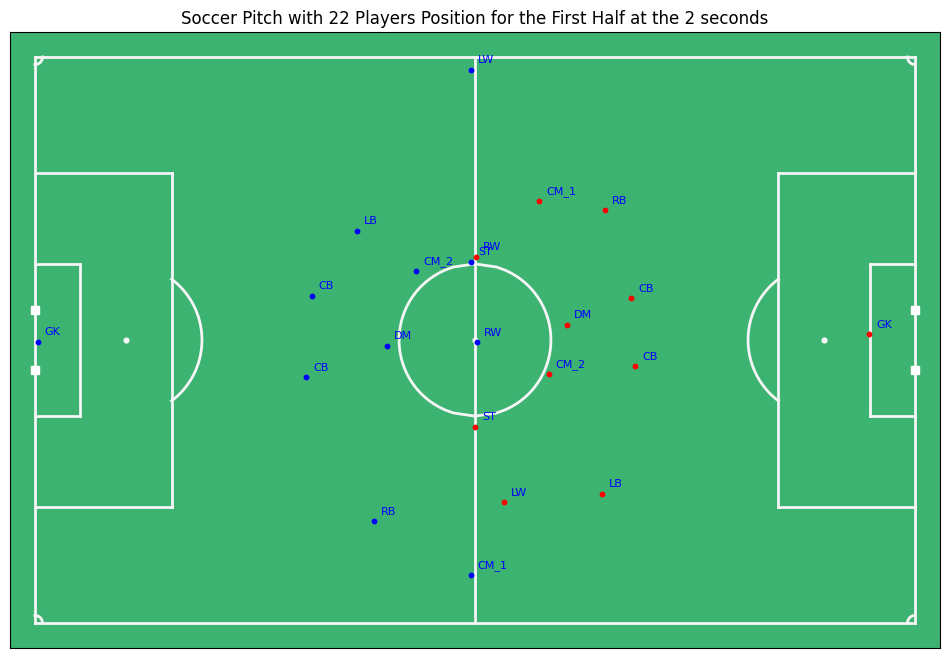

In [19]:
fig, ax = mviz.plot_pitch()

# Prepare player positions and their coordinates on the pitch
home_frame = period_1_data_home.iloc[0]
away_frame = period_1_data_away.iloc[0]
pos_x = [[float(home_frame.iloc[i]), period_1_data_home.columns[i]] for i in range(3, period_1_data_home.shape[1] - 2) if "-x" in period_1_data_home.columns[i]]
pos_y = [[float(home_frame.iloc[i]), period_1_data_home.columns[i]] for i in range(3, period_1_data_home.shape[1] - 2) if "-y" in period_1_data_home.columns[i]]
pos_x = pos_x + [[float(away_frame.iloc[i]), period_1_data_away.columns[i]] for i in range(3, period_1_data_away.shape[1]) if "-x" in period_1_data_away.columns[i]]
pos_y = pos_y + [[float(away_frame.iloc[i]), period_1_data_away.columns[i]] for i in range(3, period_1_data_away.shape[1]) if "-y" in period_1_data_away.columns[i]]

data_x, col_x = [item[0] for item in pos_x], [item[1] for item in pos_x]
data_y, col_y = [item[0] for item in pos_y], [item[1] for item in pos_y]

positions_x = pd.DataFrame([data_x], columns=col_x)
positions_y = pd.DataFrame([data_y], columns=col_y)

# Changing the dataset to meter or pitch coordinates
positions_x = mio.to_metric_coordinates(positions_x)
positions_y = mio.to_metric_coordinates(positions_y)

MEAN_X_POS = positions_x.mean(axis=1)[0]
DIRECTION_TO_GOAL = "<--" if MEAN_X_POS > 0 else "-->"
DIRECTION_TO_GOAL += " Direction To Goal"
player_pos = ["RB", "CB", "CB", "LB", "CM_1", "DM", "CM_2", "LW", "RW", "ST", "GK", "GK", "RB", "CB", "CB", "LB", "CM_1", "DM", "CM_2", "LW", "RW", "ST"] # TODO: MIGHT BE FIX THIS LATER

# Annotate player names
for i, (x, y, name) in enumerate(zip(positions_x.iloc[0], positions_y.iloc[0], player_pos)):
    color = "red"
    if i > 10:
        color = "blue"
    ax.scatter(x, y, color=color, s=10, zorder=2)  # Plot red dot
    ax.annotate(name, (x, y), xytext=(5, 5), textcoords="offset points", fontsize=8, color='blue')
# ax.annotate(DIRECTION_TO_GOAL, (MEAN_X_POS, 29.55), xytext=(MEAN_X_POS, 29.55), textcoords="offset points", fontsize=18, color="red")

seconds = home_frame.iloc[2]
plt.title(f"Soccer Pitch with 22 Players Position for the First Half at the {seconds} seconds")
plt.show()

In [20]:
period_1_data_home

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Home-P_8-x,Home-P_8-y,Home-P_9-x,Home-P_9-y,Home-P_10-x,Home-P_10-y,Home-P_11-x,Home-P_11-y,ball-x,ball-y
49,1,50,2,0.64779,0.27056,0.67763,0.42627,0.68182,0.54645,0.64443,...,0.53309,0.78647,0.50151,0.35328,0.50054,0.65342,0.94802,0.48966,0.50216,0.50376
50,1,51,2.04,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,...,0.53316,0.78648,0.5014,0.35295,0.50046,0.65322,0.94791,0.48986,0.50216,0.50376
51,1,52,2.08,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,...,0.53323,0.78651,0.50128,0.35261,0.50036,0.65297,0.94779,0.49005,0.50216,0.50376
52,1,53,2.12,0.64805,0.26978,0.67767,0.42637,0.6806,0.54582,0.64418,...,0.53328,0.78657,0.50115,0.35226,0.50025,0.65270,0.94766,0.49025,0.50216,0.50376
53,1,54,2.16,0.64815,0.26943,0.67769,0.42634,0.6802,0.54562,0.64409,...,0.53334,0.78658,0.50102,0.35198,0.50011,0.65247,0.94756,0.49039,0.5004,0.50384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67936,1,67937,2717.48,0.51337,0.71683,0.52318,0.78966,0.54702,0.86195,0.51242,...,0.40066,0.50905,0.35073,0.59980,0.337,0.79222,0.81546,0.72958,0.00883,0.47469
67937,1,67938,2717.52,0.51339,0.71801,0.52312,0.79035,0.54692,0.86271,0.51242,...,0.40095,0.50993,0.35105,0.60026,0.33727,0.79263,0.81461,0.73064,0.00883,0.47469
67938,1,67939,2717.56,0.5134,0.71929,0.52312,0.79124,0.54677,0.86355,0.51242,...,0.40122,0.51062,0.35136,0.60081,0.33756,0.79303,0.81413,0.73124,0.00883,0.47469
67939,1,67940,2717.6,0.51342,0.72035,0.52315,0.79171,0.54673,0.86423,0.51242,...,0.40148,0.51078,0.35166,0.60165,0.33781,0.79344,0.81385,0.73124,0.00883,0.47469


In [21]:
period_1_data_away

,Period,Frame,Time[s],Away-P_1-x,Away-P_1-y,Away-P_2-x,Away-P_2-y,Away-P_3-x,Away-P_3-y,Away-P_4-x,...,Away-P_8-x,Away-P_8-y,Away-P_9-x,Away-P_9-y,Away-P_10-x,Away-P_10-y,Away-P_11-x,Away-P_11-y,ball-x,ball-y
49,1,50,2,0.00315,0.50293,0.38522,0.82051,0.30852,0.56601,0.31473,...,0.43292,0.37749,0.49513,0.02253,0.50216,0.50401,0.49546,0.36198,0.50216,0.50376
50,1,51,2.04,0.00315,0.50293,0.38528,0.82061,0.3085,0.56600,0.31453,...,0.43295,0.37750,0.49511,0.02246,0.50216,0.50376,0.49565,0.36179,0.50216,0.50376
51,1,52,2.08,0.00315,0.50293,0.38535,0.82071,0.30849,0.56598,0.31434,...,0.43299,0.37743,0.49508,0.02249,0.50214,0.50371,0.4958,0.36160,0.50216,0.50376
52,1,53,2.12,0.00315,0.50293,0.38542,0.82083,0.30846,0.56595,0.31415,...,0.43305,0.37735,0.49507,0.02242,0.50209,0.50366,0.49587,0.36151,0.50216,0.50376
53,1,54,2.16,0.00315,0.50293,0.3855,0.82093,0.30845,0.56595,0.31398,...,0.43311,0.37727,0.49505,0.02235,0.50203,0.50361,0.49598,0.36131,0.5004,0.50384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67936,1,67937,2717.48,0.00095,0.55662,0.40104,0.91503,0.33494,0.79087,0.3298,...,0.4305,0.63162,0.33736,0.43011,0.52637,0.93788,0.46338,0.61444,0.00883,0.47469
67937,1,67938,2717.52,0.00075,0.55671,0.40104,0.91503,0.33552,0.79133,0.33011,...,0.43062,0.63247,0.33727,0.43065,0.52626,0.93879,0.46345,0.61528,0.00883,0.47469
67938,1,67939,2717.56,0.00063,0.55671,0.40104,0.91503,0.33631,0.79184,0.33046,...,0.43075,0.63337,0.33729,0.43166,0.52624,0.93940,0.4636,0.61612,0.00883,0.47469
67939,1,67940,2717.6,0.00063,0.55671,0.40104,0.91503,0.33781,0.79344,0.3309,...,0.43091,0.63441,0.33734,0.43225,0.52621,0.94018,0.46374,0.61695,0.00883,0.47469


## Tracking for individual Players for the First Period

In [22]:
period_1_data = pd.concat([period_1_data_home.iloc[:3000, :-2],  period_1_data_away.iloc[:3000, 3:]], axis=1)

In [23]:
period_1_data

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Away-P_8-x,Away-P_8-y,Away-P_9-x,Away-P_9-y,Away-P_10-x,Away-P_10-y,Away-P_11-x,Away-P_11-y,ball-x,ball-y
49,1,50,2,0.64779,0.27056,0.67763,0.42627,0.68182,0.54645,0.64443,...,0.43292,0.37749,0.49513,0.02253,0.50216,0.50401,0.49546,0.36198,0.50216,0.50376
50,1,51,2.04,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,...,0.43295,0.37750,0.49511,0.02246,0.50216,0.50376,0.49565,0.36179,0.50216,0.50376
51,1,52,2.08,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,...,0.43299,0.37743,0.49508,0.02249,0.50214,0.50371,0.4958,0.36160,0.50216,0.50376
52,1,53,2.12,0.64805,0.26978,0.67767,0.42637,0.6806,0.54582,0.64418,...,0.43305,0.37735,0.49507,0.02242,0.50209,0.50366,0.49587,0.36151,0.50216,0.50376
53,1,54,2.16,0.64815,0.26943,0.67769,0.42634,0.6802,0.54562,0.64409,...,0.43311,0.37727,0.49505,0.02235,0.50203,0.50361,0.49598,0.36131,0.5004,0.50384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,1,3045,121.8,0.30833,0.04158,0.46844,0.25637,0.5266,0.51596,0.45238,...,0.27061,0.41806,0.29899,0.09838,0.42529,0.24479,0.40971,0.40538,0.18937,0.31894
3045,1,3046,121.84,0.30725,0.04257,0.46743,0.25565,0.52601,0.51498,0.45175,...,0.27,0.41815,0.29855,0.09879,0.425,0.24457,0.40936,0.40560,0.18828,0.31780
3046,1,3047,121.88,0.30615,0.04357,0.46643,0.25493,0.52541,0.51396,0.45113,...,0.26939,0.41817,0.29809,0.09900,0.42472,0.24435,0.40901,0.40582,0.18721,0.31672
3047,1,3048,121.92,0.30503,0.04480,0.46544,0.25420,0.52483,0.51298,0.45053,...,0.26879,0.41819,0.29766,0.09920,0.42444,0.24404,0.40867,0.40605,0.18612,0.31556


In [54]:
def player_tracking(dataset: pd.DataFrame, players: List[int] = [11], plot_ball=True, side="Home", markersize: int = 1):
    fig, ax = mviz.plot_pitch()
    color_map = Colormap("colorbrewer:Dark2_8")
    ball_is_not_there = plot_ball
    
    for i, player in enumerate(players):
        x = f"{side}-P_{player}-x"
        y = f"{side}-P_{player}-y"
    
        # Prepare player positions and their coordinates on the pitch
        data_x = pd.to_numeric(dataset[x], errors='coerce')
        data_y = pd.to_numeric(dataset[y], errors='coerce')
        
        # Create DataFrames with a single column for x and y coordinate of a player
        positions_x = pd.DataFrame(data_x, columns=[x])
        positions_y = pd.DataFrame(data_y, columns=[y])
        
        # Changing the dataset to metric or pitch coordinates
        positions_x = mio.to_metric_coordinates(positions_x)
        positions_y = mio.to_metric_coordinates(positions_y)

        color = color_map((i + 1) / len(players))
        
        # Plot player movement with arrows
        for j in range(len(positions_x) - 1):
            dx = positions_x[x].iloc[j+1] - positions_x[x].iloc[j]
            dy = positions_y[y].iloc[j+1] - positions_y[y].iloc[j]
            if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                ax.arrow(positions_x[x].iloc[j], positions_y[y].iloc[j], dx, dy, head_width=1.2, head_length=1.2, fc=color, ec=color, linestyle="dotted", length_includes_head=True)

        
        # Plot the player path with dots and lines
        ax.plot(positions_x[x], positions_y[y], marker=".", linestyle="-.", markersize=markersize, 
                color=color, zorder=3, label=f"Player {player} - {side}")
        
        ax.annotate("Initial Point", (positions_x[x].iloc[0], positions_y[y].iloc[0]), 
                    xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)
        
        if ball_is_not_there:
            ba_x = pd.to_numeric(dataset["ball-x"], errors='coerce')
            ba_y = pd.to_numeric(dataset["ball-y"], errors='coerce')
            
            ba_x = mio.to_metric_coordinates(pd.DataFrame(ba_x, columns=["ball-x"]))
            ba_y = mio.to_metric_coordinates(pd.DataFrame(ba_y, columns=["ball-y"]))
            
            ax.plot(ba_x["ball-x"], ba_y["ball-y"], marker=".", linestyle="-.", markersize=int(markersize * 1.5), 
                    color="black", zorder=2, label="Ball")
            
            # Ball movement arrows
            for j in range(len(ba_x) - 1):
                dx = ba_x["ball-x"].iloc[j+1] - ba_x["ball-x"].iloc[j]
                dy = ba_y["ball-y"].iloc[j+1] - ba_y["ball-y"].iloc[j]
                if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                    ax.arrow(ba_x["ball-x"].iloc[j], ba_y["ball-y"].iloc[j], dx, dy, head_width=1.2, head_length=1.2, fc='black', ec='black', linestyle="dotted", length_includes_head=True)
            
            ax.annotate("Initial Point", (ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0]), 
                        xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
            
        ball_is_not_there = False
    
    start_seconds = dataset["Time[s]"].iloc[0]
    end_seconds = dataset["Time[s]"].iloc[-1]
    pl = [i for i in players]
    ax.set_title(f"Tracking for Player {pl} in the First Half from {start_seconds} seconds to {float(end_seconds) // 60} minutes")
    ax.legend(title="Player and Ball colors", loc='upper left', fontsize=8)   
    
    plt.show()

In [25]:
# player_tracking(period_1_data_home)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Grouping players time interval on 1 second interval

In [26]:
# df_home['Period'] = pd.to_numeric(df_home['Period'], errors='coerce')
# period_1_data_home = df_home[df_home["Period"] == 1]
# period_1_data_home = period_1_data_home[49:]

In [27]:
# period_1_data_home = fill_nan_with_adjacent_average(period_1_data_home)

In [28]:
period_1_data

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Away-P_8-x,Away-P_8-y,Away-P_9-x,Away-P_9-y,Away-P_10-x,Away-P_10-y,Away-P_11-x,Away-P_11-y,ball-x,ball-y
49,1,50,2,0.64779,0.27056,0.67763,0.42627,0.68182,0.54645,0.64443,...,0.43292,0.37749,0.49513,0.02253,0.50216,0.50401,0.49546,0.36198,0.50216,0.50376
50,1,51,2.04,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,...,0.43295,0.37750,0.49511,0.02246,0.50216,0.50376,0.49565,0.36179,0.50216,0.50376
51,1,52,2.08,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,...,0.43299,0.37743,0.49508,0.02249,0.50214,0.50371,0.4958,0.36160,0.50216,0.50376
52,1,53,2.12,0.64805,0.26978,0.67767,0.42637,0.6806,0.54582,0.64418,...,0.43305,0.37735,0.49507,0.02242,0.50209,0.50366,0.49587,0.36151,0.50216,0.50376
53,1,54,2.16,0.64815,0.26943,0.67769,0.42634,0.6802,0.54562,0.64409,...,0.43311,0.37727,0.49505,0.02235,0.50203,0.50361,0.49598,0.36131,0.5004,0.50384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,1,3045,121.8,0.30833,0.04158,0.46844,0.25637,0.5266,0.51596,0.45238,...,0.27061,0.41806,0.29899,0.09838,0.42529,0.24479,0.40971,0.40538,0.18937,0.31894
3045,1,3046,121.84,0.30725,0.04257,0.46743,0.25565,0.52601,0.51498,0.45175,...,0.27,0.41815,0.29855,0.09879,0.425,0.24457,0.40936,0.40560,0.18828,0.31780
3046,1,3047,121.88,0.30615,0.04357,0.46643,0.25493,0.52541,0.51396,0.45113,...,0.26939,0.41817,0.29809,0.09900,0.42472,0.24435,0.40901,0.40582,0.18721,0.31672
3047,1,3048,121.92,0.30503,0.04480,0.46544,0.25420,0.52483,0.51298,0.45053,...,0.26879,0.41819,0.29766,0.09920,0.42444,0.24404,0.40867,0.40605,0.18612,0.31556


In [29]:
period_1_data = period_1_data.drop(columns=["Frame"])

In [30]:
period_1_data

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,Away-P_8-x,Away-P_8-y,Away-P_9-x,Away-P_9-y,Away-P_10-x,Away-P_10-y,Away-P_11-x,Away-P_11-y,ball-x,ball-y
49,1,2,0.64779,0.27056,0.67763,0.42627,0.68182,0.54645,0.64443,0.77118,...,0.43292,0.37749,0.49513,0.02253,0.50216,0.50401,0.49546,0.36198,0.50216,0.50376
50,1,2.04,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,0.77154,...,0.43295,0.37750,0.49511,0.02246,0.50216,0.50376,0.49565,0.36179,0.50216,0.50376
51,1,2.08,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,0.77197,...,0.43299,0.37743,0.49508,0.02249,0.50214,0.50371,0.4958,0.36160,0.50216,0.50376
52,1,2.12,0.64805,0.26978,0.67767,0.42637,0.6806,0.54582,0.64418,0.77242,...,0.43305,0.37735,0.49507,0.02242,0.50209,0.50366,0.49587,0.36151,0.50216,0.50376
53,1,2.16,0.64815,0.26943,0.67769,0.42634,0.6802,0.54562,0.64409,0.77287,...,0.43311,0.37727,0.49505,0.02235,0.50203,0.50361,0.49598,0.36131,0.5004,0.50384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,1,121.8,0.30833,0.04158,0.46844,0.25637,0.5266,0.51596,0.45238,0.64225,...,0.27061,0.41806,0.29899,0.09838,0.42529,0.24479,0.40971,0.40538,0.18937,0.31894
3045,1,121.84,0.30725,0.04257,0.46743,0.25565,0.52601,0.51498,0.45175,0.64165,...,0.27,0.41815,0.29855,0.09879,0.425,0.24457,0.40936,0.40560,0.18828,0.31780
3046,1,121.88,0.30615,0.04357,0.46643,0.25493,0.52541,0.51396,0.45113,0.64110,...,0.26939,0.41817,0.29809,0.09900,0.42472,0.24435,0.40901,0.40582,0.18721,0.31672
3047,1,121.92,0.30503,0.04480,0.46544,0.25420,0.52483,0.51298,0.45053,0.64050,...,0.26879,0.41819,0.29766,0.09920,0.42444,0.24404,0.40867,0.40605,0.18612,0.31556


In [31]:
# Convert all columns to numeric
for col in period_1_data.columns:
    if col != "Period" and col != "Time[s]":
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce')
    else:
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce').astype(int)

avg_1_sec = pd.DataFrame()

# Calculate averages for each column
for col in period_1_data.columns:
    averages = []
    for i in range(0, len(period_1_data), 25):
        group = period_1_data[col].iloc[i:i+25]
        avg = group.mean()
        averages.append(avg)
    
    # Add the averages for this column to avg_1_sec
    avg_1_sec[col] = averages   

# avg_1_sec.reset_index(drop=True, inplace=True)
avg_1_sec.index = range(1, len(avg_1_sec) + 1)

In [32]:
avg_1_sec = avg_1_sec.iloc[:35]
avg_1_sec

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,Away-P_8-x,Away-P_8-y,Away-P_9-x,Away-P_9-y,Away-P_10-x,Away-P_10-y,Away-P_11-x,Away-P_11-y,ball-x,ball-y
1,1.0,2.0,0.648977,0.267991,0.677310,0.426190,0.676776,0.545300,0.643221,0.776967,...,0.433924,0.376337,0.495544,0.021134,0.502653,0.504083,0.497514,0.361437,0.478004,0.504892
2,1.0,3.0,0.650789,0.270286,0.675239,0.425550,0.665746,0.549138,0.641799,0.791332,...,0.439575,0.372730,0.503937,0.017368,0.510893,0.507302,0.510787,0.366744,0.416908,0.507822
3,1.0,4.0,0.651538,0.280022,0.676080,0.422136,0.657685,0.555499,0.645750,0.804490,...,0.453785,0.368546,0.528435,0.013048,0.533364,0.518076,0.538209,0.384402,0.411282,0.510096
4,1.0,5.0,0.661151,0.268981,0.682081,0.410478,0.656046,0.552907,0.655068,0.800052,...,0.477036,0.361347,0.563526,0.013747,0.565490,0.524307,0.559190,0.400871,0.421370,0.506699
5,1.0,6.0,0.673464,0.232932,0.684514,0.389209,0.654967,0.541258,0.663216,0.772410,...,0.497825,0.348813,0.586092,0.016251,0.598187,0.520567,0.571094,0.383250,0.431361,0.404810
6,1.0,7.0,0.669840,0.190549,0.683956,0.360810,0.656676,0.524347,0.668404,0.733431,...,0.506775,0.323630,0.580956,0.015669,0.623798,0.514865,0.593114,0.339058,0.443172,0.248712
7,1.0,8.0,0.657696,0.153282,0.686473,0.318212,0.667702,0.505663,0.676364,0.695906,...,0.509674,0.288763,0.564866,0.011931,0.642475,0.511593,0.621391,0.292233,0.458821,0.210707
8,1.0,9.0,0.647824,0.136526,0.690394,0.279177,0.678354,0.489310,0.683986,0.674580,...,0.507827,0.257566,0.556728,0.012151,0.655416,0.515296,0.645250,0.249025,0.465748,0.194380
9,1.0,10.0,0.639936,0.143972,0.683520,0.282219,0.674642,0.489078,0.680512,0.687184,...,0.489205,0.246441,0.556850,0.015587,0.659315,0.527951,0.654587,0.235451,0.413000,0.218343
10,1.0,11.0,0.636148,0.160667,0.666208,0.319347,0.660450,0.502044,0.667983,0.723948,...,0.460870,0.263358,0.560816,0.019171,0.654660,0.547421,0.645100,0.254440,0.320293,0.275645


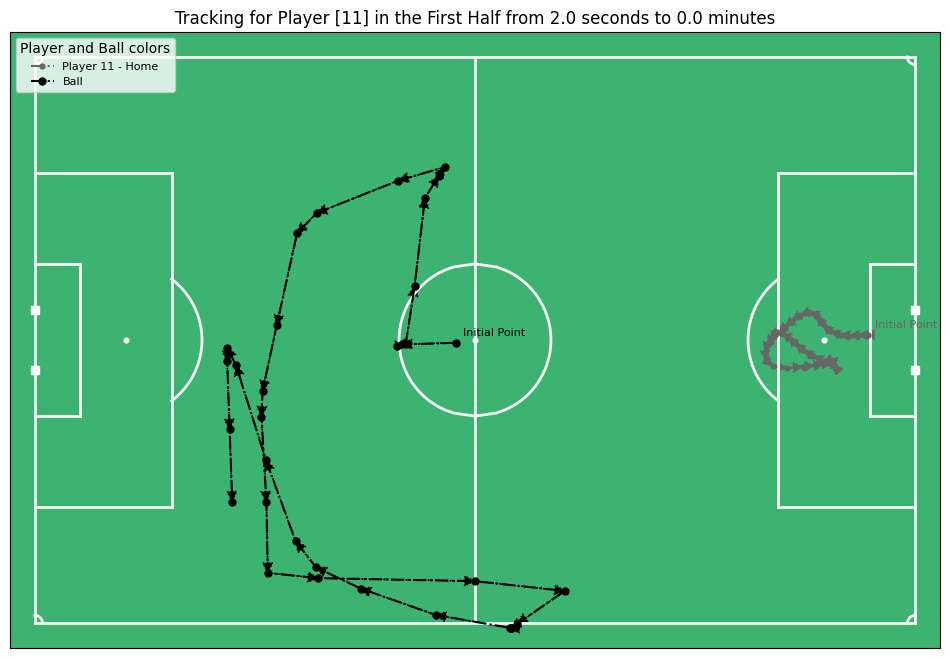

In [33]:
player_tracking(avg_1_sec.loc[:"Home-P_11-y"], plot_ball=True, side="Home", markersize=7)

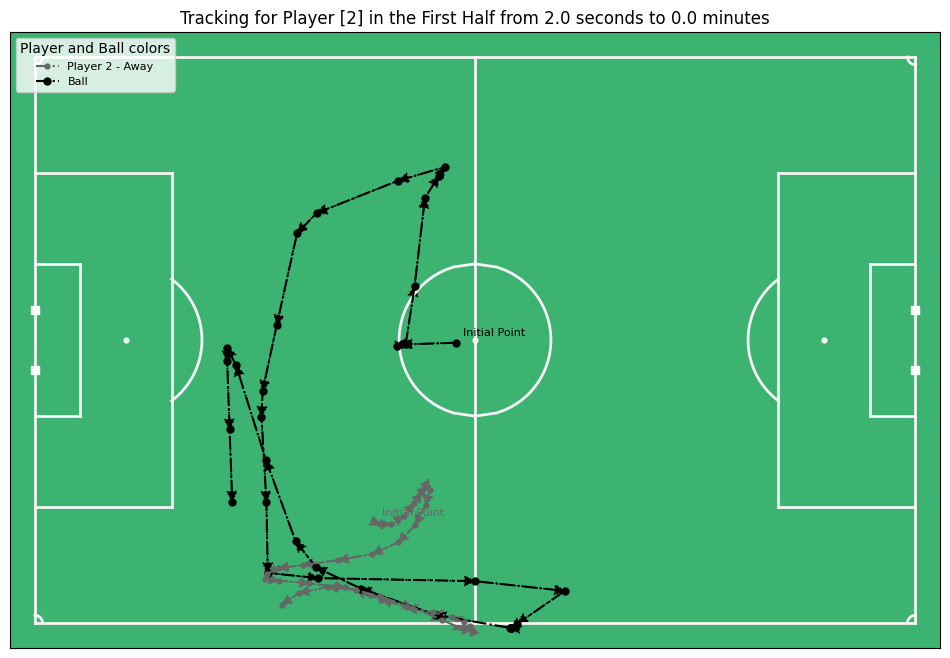

In [34]:
player_tracking(avg_1_sec, [2], side="Away", markersize=7)

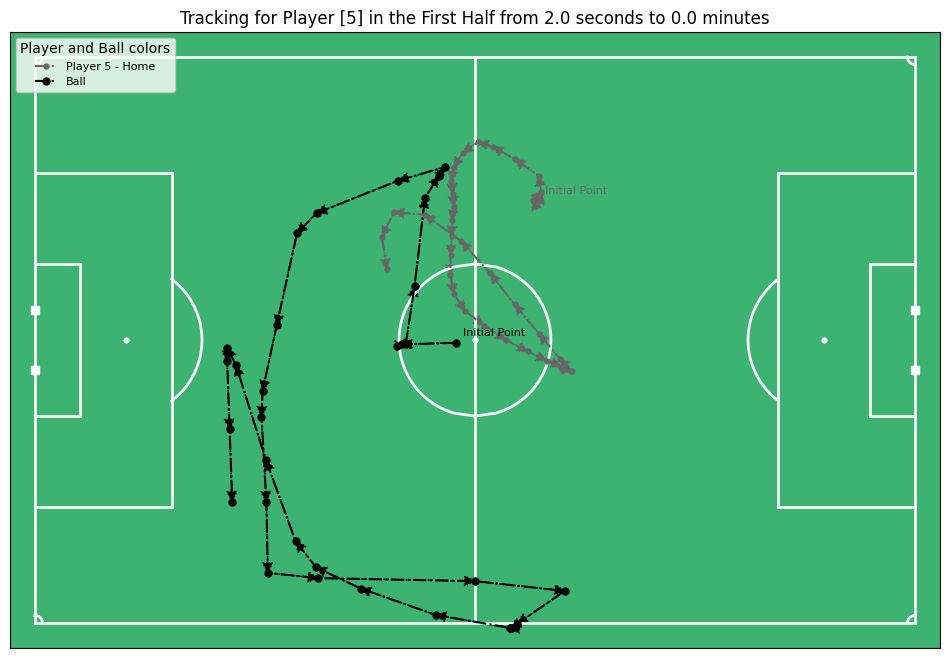

In [35]:
player_tracking(avg_1_sec, [5], markersize=7)

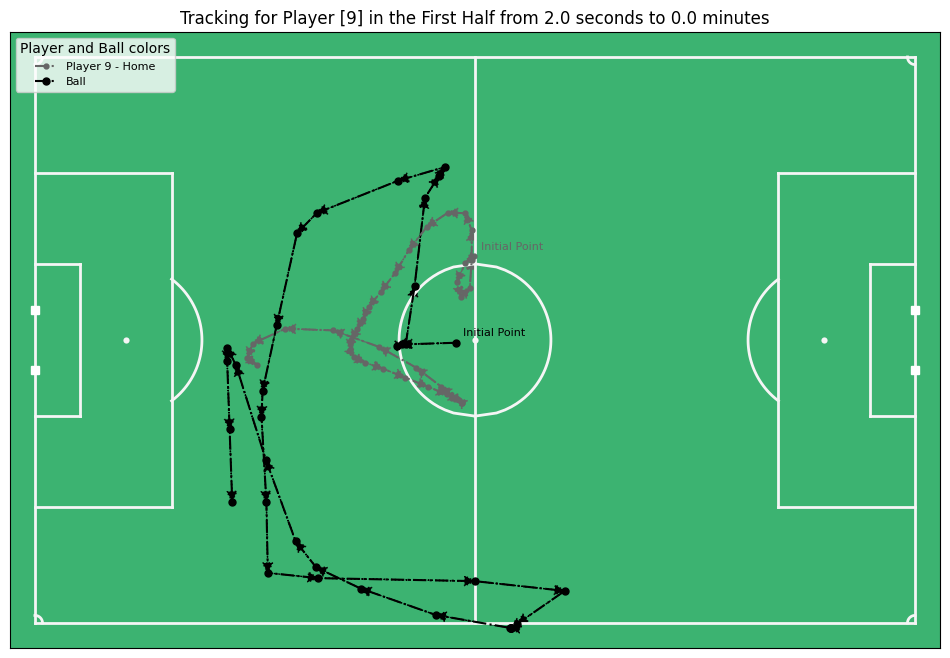

In [36]:
player_tracking(avg_1_sec, [9], markersize=7)

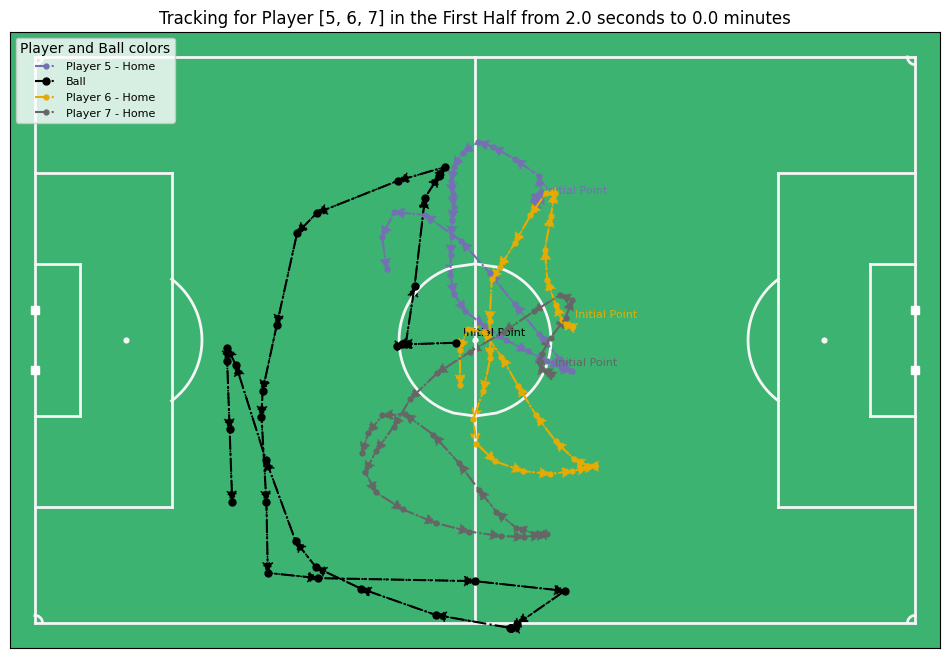

In [39]:
player_tracking(avg_1_sec, [5, 6, 7], markersize=7)

In [40]:
# Calculate players speed
def players_speed():
    MPS_TO_MPH = 2.23694
    player_columns = [(f'P_{i}-x', f'P_{i}-y') for i in range(1, 12)]
    
    for i, (x_col, y_col) in enumerate(player_columns, 1):
        # Calculate Euclidean distance between consecutive points
        x_diff = avg_1_sec[x_col].diff()
        y_diff = avg_1_sec[y_col].diff()
        distance = np.sqrt(x_diff**2 + y_diff**2)
        
        # Calculate time difference between frames
        time_diff = avg_1_sec['Time[s]'].diff()
        
        # Calculate speed (distance / time)
        # Note: First row will be NaN as we can't calculate speed for a single point
        speed = distance / time_diff
        speed_mph = speed * MPS_TO_MPH
        
        avg_1_sec[f"P_{i}_speed"] = speed_mph

# players_speed()

In [41]:
avg_1_sec

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,Away-P_8-x,Away-P_8-y,Away-P_9-x,Away-P_9-y,Away-P_10-x,Away-P_10-y,Away-P_11-x,Away-P_11-y,ball-x,ball-y
1,1.0,2.0,0.648977,0.267991,0.677310,0.426190,0.676776,0.545300,0.643221,0.776967,...,0.433924,0.376337,0.495544,0.021134,0.502653,0.504083,0.497514,0.361437,0.478004,0.504892
2,1.0,3.0,0.650789,0.270286,0.675239,0.425550,0.665746,0.549138,0.641799,0.791332,...,0.439575,0.372730,0.503937,0.017368,0.510893,0.507302,0.510787,0.366744,0.416908,0.507822
3,1.0,4.0,0.651538,0.280022,0.676080,0.422136,0.657685,0.555499,0.645750,0.804490,...,0.453785,0.368546,0.528435,0.013048,0.533364,0.518076,0.538209,0.384402,0.411282,0.510096
4,1.0,5.0,0.661151,0.268981,0.682081,0.410478,0.656046,0.552907,0.655068,0.800052,...,0.477036,0.361347,0.563526,0.013747,0.565490,0.524307,0.559190,0.400871,0.421370,0.506699
5,1.0,6.0,0.673464,0.232932,0.684514,0.389209,0.654967,0.541258,0.663216,0.772410,...,0.497825,0.348813,0.586092,0.016251,0.598187,0.520567,0.571094,0.383250,0.431361,0.404810
6,1.0,7.0,0.669840,0.190549,0.683956,0.360810,0.656676,0.524347,0.668404,0.733431,...,0.506775,0.323630,0.580956,0.015669,0.623798,0.514865,0.593114,0.339058,0.443172,0.248712
7,1.0,8.0,0.657696,0.153282,0.686473,0.318212,0.667702,0.505663,0.676364,0.695906,...,0.509674,0.288763,0.564866,0.011931,0.642475,0.511593,0.621391,0.292233,0.458821,0.210707
8,1.0,9.0,0.647824,0.136526,0.690394,0.279177,0.678354,0.489310,0.683986,0.674580,...,0.507827,0.257566,0.556728,0.012151,0.655416,0.515296,0.645250,0.249025,0.465748,0.194380
9,1.0,10.0,0.639936,0.143972,0.683520,0.282219,0.674642,0.489078,0.680512,0.687184,...,0.489205,0.246441,0.556850,0.015587,0.659315,0.527951,0.654587,0.235451,0.413000,0.218343
10,1.0,11.0,0.636148,0.160667,0.666208,0.319347,0.660450,0.502044,0.667983,0.723948,...,0.460870,0.263358,0.560816,0.019171,0.654660,0.547421,0.645100,0.254440,0.320293,0.275645


# Clustering players positions

In [42]:
def clustering_dataset() -> np.array:
    cm_1 = np.array([avg_1_sec["P_5-x"], avg_1_sec["P_5-y"]])
    cm_2 = np.array([avg_1_sec["P_6-x"], avg_1_sec["P_6-y"]])
    cm_3 = np.array([avg_1_sec["P_7-x"], avg_1_sec["P_7-y"]])

    X = np.concatenate([cm_1, cm_2, cm_3], axis=1).T
    label = np.array([np.full(len(avg_1_sec["P_5-x"]), 0), np.full(len(avg_1_sec["P_6-x"]), 1), np.full(len(avg_1_sec["P_7-x"]), 2)])
    label = label.reshape(-1, 1)
    label = label.flatten()
    
    return X, label

In [43]:
X, y_true = clustering_dataset()

KeyError: 'P_5-x'

In [ ]:
X.shape

In [ ]:
def clustering():
    kmeans = KMeans(n_clusters=3, random_state=0, init="random", n_init="auto").fit(X)
    kmeans_plus = KMeans(n_clusters=3, random_state=0, init="k-means++", n_init="auto").fit(X)
    b_kmeans = BisectingKMeans(n_clusters=3, random_state=0, init="random").fit(X)
    s_clustering = SpectralClustering(n_clusters=3).fit(X)
    single = AgglomerativeClustering(n_clusters=3, linkage="single").fit(X)
    complete = AgglomerativeClustering(n_clusters=3, linkage="complete").fit(X)
    average = AgglomerativeClustering(n_clusters=3, linkage="average").fit(X)
    ward = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(X)

    return kmeans, kmeans_plus, b_kmeans, s_clustering, single, complete, average, ward

In [ ]:
def accuracy():
    result = []
    clusters = clustering()
    for clus in clusters:
        result.append(clus)
        y_pred = clus.fit_predict(X)        
        acc = accuracy_score(y_true, y_pred)

        print(f"{clus}: {np.round(acc, 2)}")

accuracy()

In [ ]:
color = ["orange", "blue", "green"]
for i in range(X.shape[0]):
    if i < X.shape[0] // 3:
        plt.scatter(X[i][0], X[i][1], color="orange")
    elif i < (X.shape[0] * 2) // 3 and i > X.shape[0] // 3:
        plt.scatter(X[i][0], X[i][1], color="blue")
    else:
        plt.scatter(X[i][0], X[i][1], color="green")
    plt.grid()
plt.show()

In [ ]:
kmeans, kmeans_plus, b_kmeans, s_clustering, single_clu, complete_clu, average_clu, ward_clu = clustering()

In [ ]:
def plot_clusters():
    fig, ax = plt.subplots(4, 2, figsize=(16, 16))
    ax[0, 0].scatter(X[:, 0], X[:, 1], s=15, c=kmeans.labels_)
    ax[0, 0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=10, c="r", marker="*")
    ax[0, 0].set_title("KMeans")
    
    ax[0, 1].scatter(X[:, 0], X[:, 1], s=15, c=kmeans_plus.labels_)
    ax[0, 1].scatter(kmeans_plus.cluster_centers_[:, 0], kmeans_plus.cluster_centers_[:, 1], s=10, c="r", marker="*")
    ax[0, 1].set_title("KMeans++")
    
    ax[1, 0].scatter(X[:, 0], X[:, 1], s=15, c=b_kmeans.labels_)
    ax[1, 0].scatter(b_kmeans.cluster_centers_[:, 0], b_kmeans.cluster_centers_[:, 1], s=10, c="r", marker="*")
    ax[1, 0].set_title("BisectingKMeans")
    
    ax[1, 1].scatter(X[:, 0], X[:, 1], s=15, c=s_clustering.labels_)
    ax[1, 1].set_title("SpectralClustering")
    
    ax[2, 0].scatter(X[:, 0], X[:, 1], s=15, c=single_clu.labels_)
    ax[2, 0].set_title("Single Agglomerative Linkage")
    
    ax[2, 1].scatter(X[:, 0], X[:, 1], s=15, c=complete_clu.labels_)
    ax[2, 1].set_title("Complete Agglomerative Linkage")
    
    ax[3, 0].scatter(X[:, 0], X[:, 1], s=15, c=average_clu.labels_)
    ax[3, 0].set_title("Average Agglomerative Linkage")
    
    ax[3, 1].scatter(X[:, 0], X[:, 1], s=15, c=ward_clu.labels_)
    ax[3, 1].set_title("Ward Agglomerative Linkage")
    plt.show()
    
plot_clusters()

# Correlation Between Ball and Player

In [ ]:
ball_player = avg_1_sec.loc[:, "P_1-x":"ball-y"]

In [ ]:
ball_player

In [ ]:
x_ball_player = ball_player.loc[:, ball_player.columns.str.contains("x")]
y_ball_player = ball_player.loc[:, ball_player.columns.str.contains("y")]

x_ball_player.columns = (player_pos + [x_ball_player.columns[-1]])
y_ball_player.columns = (player_pos + [y_ball_player.columns[-1]])

In [ ]:
x_ball_player

In [ ]:
y_ball_player

#### X-coordinates correlation

In [ ]:
x_ball_player.corr()#.iloc[-1]

#### Y-coordinates correlation

In [ ]:
y_ball_player.corr()#.iloc[-1]

# Tracking players closest to the ball

In [44]:
ply_tra = avg_1_sec.loc[:, "Home-P_1-x":"ball-y"]
ply_tra.head()

,Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,Home-P_5-x,Home-P_5-y,...,Away-P_8-x,Away-P_8-y,Away-P_9-x,Away-P_9-y,Away-P_10-x,Away-P_10-y,Away-P_11-x,Away-P_11-y,ball-x,ball-y
1,0.648977,0.267991,0.677310,0.426190,0.676776,0.545300,0.643221,0.776967,0.571214,0.253519,...,0.433924,0.376337,0.495544,0.021134,0.502653,0.504083,0.497514,0.361437,0.478004,0.504892
2,0.650789,0.270286,0.675239,0.425550,0.665746,0.549138,0.641799,0.791332,0.566802,0.254574,...,0.439575,0.372730,0.503937,0.017368,0.510893,0.507302,0.510787,0.366744,0.416908,0.507822
3,0.651538,0.280022,0.676080,0.422136,0.657685,0.555499,0.645750,0.804490,0.566221,0.252008,...,0.453785,0.368546,0.528435,0.013048,0.533364,0.518076,0.538209,0.384402,0.411282,0.510096
4,0.661151,0.268981,0.682081,0.410478,0.656046,0.552907,0.655068,0.800052,0.575408,0.237664,...,0.477036,0.361347,0.563526,0.013747,0.565490,0.524307,0.559190,0.400871,0.421370,0.506699
5,0.673464,0.232932,0.684514,0.389209,0.654967,0.541258,0.663216,0.772410,0.572388,0.209819,...,0.497825,0.348813,0.586092,0.016251,0.598187,0.520567,0.571094,0.383250,0.431361,0.404810


In [45]:
players, ball = ply_tra.loc[:,"Home-P_1-x":"Away-P_11-y"], ply_tra.loc[:,"ball-x":"ball-y"]

In [46]:
players

,Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,Home-P_5-x,Home-P_5-y,...,Away-P_7-x,Away-P_7-y,Away-P_8-x,Away-P_8-y,Away-P_9-x,Away-P_9-y,Away-P_10-x,Away-P_10-y,Away-P_11-x,Away-P_11-y
1,0.648977,0.267991,0.677310,0.426190,0.676776,0.545300,0.643221,0.776967,0.571214,0.253519,...,0.401225,0.509418,0.433924,0.376337,0.495544,0.021134,0.502653,0.504083,0.497514,0.361437
2,0.650789,0.270286,0.675239,0.425550,0.665746,0.549138,0.641799,0.791332,0.566802,0.254574,...,0.404455,0.508421,0.439575,0.372730,0.503937,0.017368,0.510893,0.507302,0.510787,0.366744
3,0.651538,0.280022,0.676080,0.422136,0.657685,0.555499,0.645750,0.804490,0.566221,0.252008,...,0.412492,0.510372,0.453785,0.368546,0.528435,0.013048,0.533364,0.518076,0.538209,0.384402
4,0.661151,0.268981,0.682081,0.410478,0.656046,0.552907,0.655068,0.800052,0.575408,0.237664,...,0.422359,0.505725,0.477036,0.361347,0.563526,0.013747,0.565490,0.524307,0.559190,0.400871
5,0.673464,0.232932,0.684514,0.389209,0.654967,0.541258,0.663216,0.772410,0.572388,0.209819,...,0.429535,0.494103,0.497825,0.348813,0.586092,0.016251,0.598187,0.520567,0.571094,0.383250
6,0.669840,0.190549,0.683956,0.360810,0.656676,0.524347,0.668404,0.733431,0.545102,0.180419,...,0.443344,0.489415,0.506775,0.323630,0.580956,0.015669,0.623798,0.514865,0.593114,0.339058
7,0.657696,0.153282,0.686473,0.318212,0.667702,0.505663,0.676364,0.695906,0.520288,0.158450,...,0.462453,0.486432,0.509674,0.288763,0.564866,0.011931,0.642475,0.511593,0.621391,0.292233
8,0.647824,0.136526,0.690394,0.279177,0.678354,0.489310,0.683986,0.674580,0.503459,0.150475,...,0.477943,0.487287,0.507827,0.257566,0.556728,0.012151,0.655416,0.515296,0.645250,0.249025
9,0.639936,0.143972,0.683520,0.282219,0.674642,0.489078,0.680512,0.687184,0.486096,0.168819,...,0.483994,0.501939,0.489205,0.246441,0.556850,0.015587,0.659315,0.527951,0.654587,0.235451
10,0.636148,0.160667,0.666208,0.319347,0.660450,0.502044,0.667983,0.723948,0.475794,0.195176,...,0.478369,0.515010,0.460870,0.263358,0.560816,0.019171,0.654660,0.547421,0.645100,0.254440


In [47]:
ball

,ball-x,ball-y
1,0.478004,0.504892
2,0.416908,0.507822
3,0.411282,0.510096
4,0.421370,0.506699
5,0.431361,0.404810
6,0.443172,0.248712
7,0.458821,0.210707
8,0.465748,0.194380
9,0.413000,0.218343
10,0.320293,0.275645


In [48]:
result = pd.DataFrame()
result.index = avg_1_sec.index
result["Time[s]"] = avg_1_sec["Time[s]"]

for i in range(0, players.shape[1] - 1, 2):
    ply_x, ply_y = players.iloc[:, i], players.iloc[:, i + 1]
    eu_x = np.square(ply_x - ball["ball-x"])
    eu_y = np.square(ply_y - ball["ball-y"])
    distance = np.sqrt(eu_x + eu_y)
    result[f"{players.columns[i][:-2]}"] = distance

In [49]:
result

,Time[s],Home-P_1,Home-P_2,Home-P_3,Home-P_4,Home-P_5,Home-P_6,Home-P_7,Home-P_8,Home-P_9,...,Away-P_2,Away-P_3,Away-P_4,Away-P_5,Away-P_6,Away-P_7,Away-P_8,Away-P_9,Away-P_10,Away-P_11
1,2.0,0.292154,0.214283,0.202838,0.318311,0.268097,0.131128,0.117331,0.286926,0.154455,...,0.329935,0.180396,0.185320,0.228346,0.410089,0.076912,0.135902,0.484075,0.024662,0.144775
2,3.0,0.333352,0.271115,0.252245,0.361875,0.294284,0.190051,0.169789,0.300836,0.161486,...,0.318787,0.123242,0.138371,0.213737,0.415061,0.012468,0.136981,0.498116,0.093986,0.169459
3,4.0,0.332651,0.279025,0.250551,0.376355,0.301024,0.192764,0.169537,0.294223,0.131198,...,0.315531,0.112988,0.134712,0.222652,0.408886,0.001241,0.147793,0.510667,0.122342,0.178632
4,5.0,0.337646,0.277901,0.239182,0.375060,0.310012,0.183334,0.156709,0.268269,0.103923,...,0.304099,0.112536,0.136416,0.238727,0.387812,0.001388,0.155647,0.513040,0.145191,0.173765
5,6.0,0.296910,0.253633,0.261950,0.434611,0.240645,0.151093,0.187496,0.316372,0.062827,...,0.383272,0.187112,0.097380,0.163349,0.450964,0.089312,0.086908,0.418234,0.203054,0.141387
6,7.0,0.234011,0.265600,0.348653,0.534493,0.122693,0.164176,0.285406,0.418580,0.121338,...,0.519881,0.336554,0.157412,0.024621,0.572966,0.240703,0.098275,0.270727,0.321657,0.175058
7,8.0,0.207000,0.251760,0.361428,0.531735,0.080679,0.145600,0.288852,0.423142,0.102706,...,0.547576,0.377770,0.176174,0.002579,0.595973,0.275748,0.093160,0.225295,0.352507,0.181867
8,9.0,0.191047,0.240118,0.363572,0.527466,0.057877,0.132758,0.275714,0.433872,0.084732,...,0.571361,0.396103,0.179598,0.001671,0.613386,0.293161,0.075915,0.203678,0.372775,0.187635
9,10.0,0.238811,0.277959,0.376502,0.539792,0.088293,0.168996,0.273288,0.444101,0.079880,...,0.574220,0.364809,0.116055,0.066058,0.617092,0.292347,0.081220,0.248601,0.395637,0.242192
10,11.0,0.336132,0.348665,0.408612,0.567331,0.175088,0.242772,0.301651,0.455419,0.127107,...,0.562509,0.300701,0.012483,0.192241,0.623486,0.286852,0.141113,0.351610,0.430888,0.325499


In [81]:
idx = result.min(axis=1)
closest_to_ball = result.idxmin(axis=1)
print("\n".join(f"{i} - {ply} - {dis}" for i, (ply, dis) in enumerate(zip(closest_to_ball, idx))))

0 - Away-P_10 - 0.024662452659863374
1 - Away-P_7 - 0.012467588045809025
2 - Away-P_7 - 0.0012412567180079307
3 - Away-P_7 - 0.0013879486445830275
4 - Home-P_9 - 0.0628271716721356
5 - Away-P_5 - 0.024621050196935123
6 - Away-P_5 - 0.0025786275109057717
7 - Away-P_5 - 0.0016714213352712571
8 - Away-P_5 - 0.06605771824094439
9 - Away-P_4 - 0.012482677642236801
10 - Away-P_4 - 0.0019313077434734238
11 - Away-P_3 - 0.10211165424964966
12 - Away-P_3 - 0.003957933865036147
13 - Away-P_3 - 0.005983840773282613
14 - Home-P_10 - 0.10155340670366522
15 - Away-P_2 - 0.0017131244905143857
16 - Home-P_8 - 0.03846829887790727
17 - Home-P_4 - 0.02136322077964841
18 - Away-P_10 - 0.019022322369258618
19 - Home-P_4 - 0.05355338490674778
20 - Away-P_6 - 0.05160274074557089
21 - Away-P_6 - 0.033371233798321236
22 - Away-P_6 - 0.04652104843517528
23 - Home-P_8 - 0.037804461724569964
24 - Away-P_2 - 0.042761041039435205
25 - Away-P_2 - 0.04329923235532012
26 - Away-P_3 - 0.04413015799110636
27 - Away-P_3 

In [115]:
min_dist_to_ball = pd.DataFrame()
min_dist_to_ball["Time[s]"] = avg_1_sec["Time[s]"]
min_dist_to_ball["Players"] = closest_to_ball
for i, c in enumerate(closest_to_ball):
    min_dist_to_ball.loc[i + 1, "Home-P_1-x"] = avg_1_sec.loc[i + 1, f"{c}-x"]
    min_dist_to_ball.loc[i + 1, "Home-P_1-y"] = avg_1_sec.loc[i + 1, f"{c}-y"]
    
min_dist_to_ball["ball-x"] = avg_1_sec["ball-x"]
min_dist_to_ball["ball-y"] = avg_1_sec["ball-y"]

min_dist_to_ball

,Time[s],Players,Home-P_1-x,Home-P_1-y,ball-x,ball-y
1,2.0,Away-P_10,0.502653,0.504083,0.478004,0.504892
2,3.0,Away-P_7,0.404455,0.508421,0.416908,0.507822
3,4.0,Away-P_7,0.412492,0.510372,0.411282,0.510096
4,5.0,Away-P_7,0.422359,0.505725,0.421370,0.506699
5,6.0,Home-P_9,0.494125,0.407635,0.431361,0.404810
6,7.0,Away-P_5,0.443923,0.224102,0.443172,0.248712
7,8.0,Away-P_5,0.460293,0.208590,0.458821,0.210707
8,9.0,Away-P_5,0.465775,0.192709,0.465748,0.194380
9,10.0,Away-P_5,0.462668,0.174792,0.413000,0.218343
10,11.0,Away-P_4,0.310170,0.282949,0.320293,0.275645


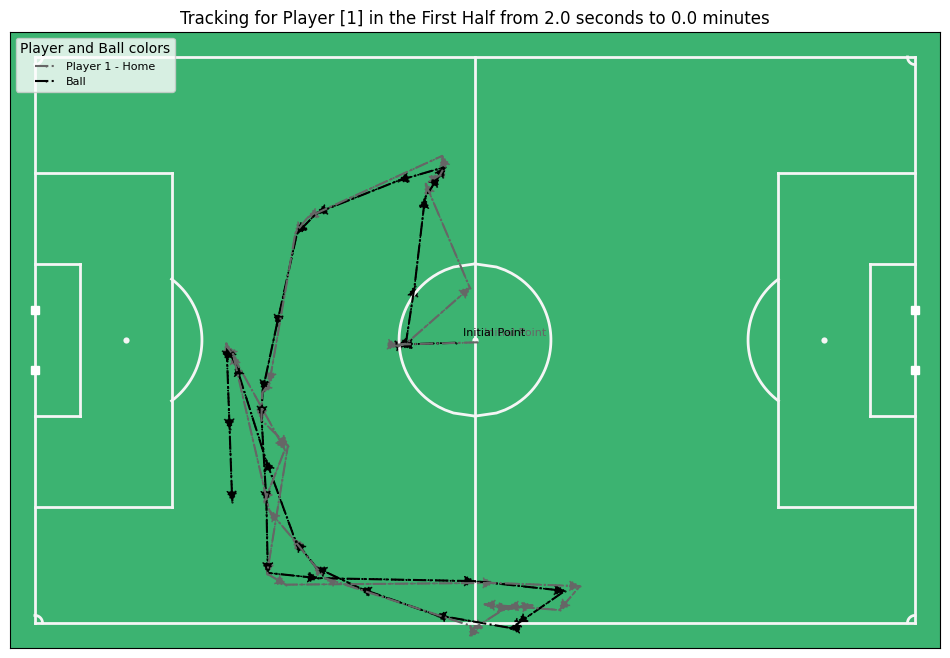

In [116]:
player_tracking(min_dist_to_ball, players = [1], side="Home")

In [ ]:
"""
set-piece (corner, goal-kick, offside, )passes, interceptions, or duels.
"""

In [ ]:
"""
Plot the ball and the players next to the ball at each interval
"""